In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import matplotlib as mpl
import torch.nn.functional as F
from torch.utils.data import random_split
import numpy as np

In [2]:
# Define a simple feed-forward neural network
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28*28, 128)  # input layer
        self.fc2 = nn.Linear(128, 64)     # hidden layer
        self.fc3 = nn.Linear(64, 10)      # output layer

    def forward(self, x):
        x = x.view(-1, 28*28)  # flatten the input images
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [3]:
# Use the MNIST dataset
dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
# Define the size of the subsets
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

# Split the dataset
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create data loaders
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, batch_size=64)

In [4]:
# Instantiate the network, loss function, and optimizer
net = Net()
criterion = nn.MSELoss()
optimizer = optim.SGD(net.parameters(), lr=0.01)

In [5]:
epoch_losses_1 = []  # to store the average loss per epoch
epoch_val_losses_1 = []  # to store the average validation loss per epoch

# Training and validation loop
for epoch in range(5):                    #<--------- Choose epoch number (here 5 training epochs)
    epoch_loss = 0  # to accumulate the loss within an epoch
    num_batches = 0  # to count the number of batches

    net.train()  # switch to training mode

    for i, (images, labels) in enumerate(train_loader):
        # Convert labels to one-hot encoding
        labels_one_hot = torch.zeros(labels.size(0), 10).scatter_(1, labels.view(-1, 1), 1)
        
        optimizer.zero_grad()   # zero the gradient buffers
        outputs = net(images)   # forward pass
        
        loss = criterion(outputs, labels_one_hot)  # compute the loss
        epoch_loss += loss.item()  # accumulate the loss within the epoch
        num_batches += 1  # count the number of batches

        loss.backward()  # backpropagation
        optimizer.step()  # update the weights

    epoch_losses_1.append(epoch_loss / num_batches)  # store the average loss per epoch

    # After training for one epoch, we now evaluate on the validation set
    net.eval()  # switch to evaluation mode

    val_loss = 0
    num_val_batches = 0

    with torch.no_grad():  # deactivate autograd engine to reduce memory usage and speed up computations
        for i, (images, labels) in enumerate(val_loader):
            labels_one_hot = torch.zeros(labels.size(0), 10).scatter_(1, labels.view(-1, 1), 1)
            outputs = net(images)   # forward pass
            loss = criterion(outputs, labels_one_hot)  # compute the loss
            val_loss += loss.item()
            num_val_batches += 1

    epoch_val_losses_1.append(val_loss / num_val_batches)

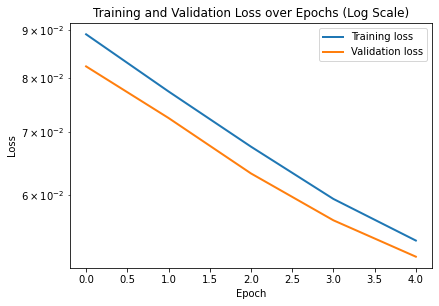

In [6]:
plt.figure(figsize=(6.5, 4.5))
plt.semilogy(epoch_losses_1, linewidth=2, label='Training loss')
plt.semilogy(epoch_val_losses_1, linewidth=2, label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs (Log Scale)')
plt.legend()
#plt.savefig('SGD_FFNN_loss_1', facecolor='w', bbox_inches='tight')
plt.show()

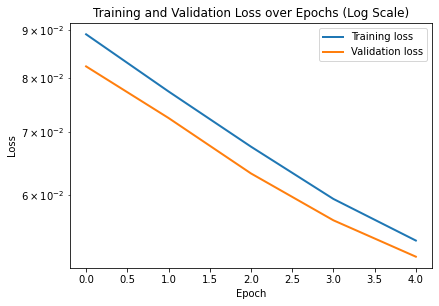

In [7]:
plt.figure(figsize=(6.5, 4.5))

# Plot the training loss
plt.semilogy(epoch_losses_1, linewidth=2, label='Training loss')

# Plot the validation loss
plt.semilogy(epoch_val_losses_1, linewidth=2, label='Validation loss')

# Find the index where validation loss exceeds training loss
index = next((i for i, (train_loss, val_loss) in enumerate(zip(epoch_losses_1, epoch_val_losses_1)) if val_loss > train_loss), None)

# Plot the difference between validation loss and training loss
if index is not None:
    diff_losses = [val_loss - train_loss for train_loss, val_loss in zip(epoch_losses_1, epoch_val_losses_1)]
    plt.semilogy(range(index, len(epoch_val_losses_1)), diff_losses[index:], linewidth=2, label='Difference')

    # Add an annotation
    plt.annotate(f'Validation exceeds at epoch {index}', xy=(index, epoch_val_losses_1[index]), xytext=(index+30, epoch_val_losses_1[index-5]),
                arrowprops=dict(arrowstyle='->', linewidth=1.5), fontsize=11.5)

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs (Log Scale)')
plt.legend()
#plt.savefig('SGD_FFNN_loss_diff_1', facecolor='w', bbox_inches='tight')
plt.show()

In [8]:
learning_rates = [0.01, 0.05, 0.1]

# Initialize dictionaries to store the losses for the different learning rates
epoch_losses = {lr: [] for lr in learning_rates}
epoch_val_losses = {lr: [] for lr in learning_rates}

# Train for each learning rate
for lr in learning_rates:
    # Instantiate the network, loss function, and optimizer for each learning rate
    net = Net()
    criterion = nn.MSELoss()
    optimizer = optim.SGD(net.parameters(), lr=lr)
    
    # Calculate and store initial losses
    net.eval()
    with torch.no_grad():
        initial_train_loss = sum(criterion(net(images), torch.zeros(labels.size(0), 10).scatter_(1, labels.view(-1, 1), 1)).item()
                                 for images, labels in train_loader) / len(train_loader)
        initial_val_loss = sum(criterion(net(images), torch.zeros(labels.size(0), 10).scatter_(1, labels.view(-1, 1), 1)).item()
                               for images, labels in val_loader) / len(val_loader)
    epoch_losses[lr].append(initial_train_loss)
    epoch_val_losses[lr].append(initial_val_loss)
    
    
    # Training and validation loop
    for epoch in range(5):                  #<--------- Choose epoch number (here 5 training epochs)
        epoch_loss = 0  # to accumulate the loss within an epoch
        num_batches = 0  # to count the number of batches

        net.train()  # switch to training mode

        for i, (images, labels) in enumerate(train_loader):
            labels_one_hot = torch.zeros(labels.size(0), 10).scatter_(1, labels.view(-1, 1), 1)

            optimizer.zero_grad()   # zero the gradient buffers
            outputs = net(images)   # forward pass

            loss = criterion(outputs, labels_one_hot)  # compute the loss
            epoch_loss += loss.item()  # accumulate the loss within the epoch
            num_batches += 1  # count the number of batches

            loss.backward()  # backpropagation
            optimizer.step()  # update the weights

        epoch_losses[lr].append(epoch_loss / num_batches)  # store the average loss per epoch

        net.eval()  # switch to evaluation mode

        val_loss = 0
        num_val_batches = 0

        with torch.no_grad():
            for i, (images, labels) in enumerate(val_loader):
                labels_one_hot = torch.zeros(labels.size(0), 10).scatter_(1, labels.view(-1, 1), 1)
                outputs = net(images)   # forward pass
                loss = criterion(outputs, labels_one_hot)  # compute the loss
                val_loss += loss.item()
                num_val_batches += 1

        epoch_val_losses[lr].append(val_loss / num_val_batches)

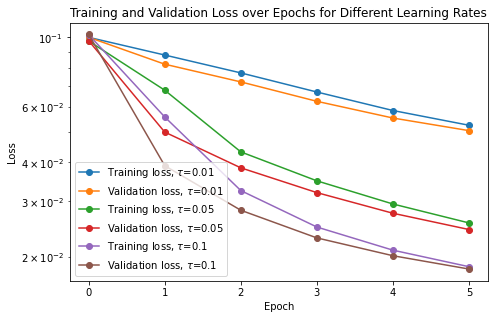

In [9]:
# Now let's plot the results
plt.figure(figsize=(7.5, 4.75))
for lr in learning_rates:
    plt.semilogy(epoch_losses[lr], '-o', label=f'Training loss, $\\tau$={lr}')
    plt.semilogy(epoch_val_losses[lr], '-o', label=f'Validation loss, $\\tau$={lr}')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs for Different Learning Rates')
plt.legend()

#plt.savefig('SGD_FFNN_loss_lr_log', facecolor='w', bbox_inches='tight')
plt.show()

In [10]:
# Load the MNIST test dataset
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)

In [11]:
# Choose an image from the dataset
image, label = test_dataset[8]
image = image.view(-1, 28*28)  # reshape the image

epoch_losses_2 = []
epoch_val_losses_2 = []

# Before training
net.eval()  # set the model to evaluation mode
with torch.no_grad():  # turn off gradients for this block
    output_before = net(image)
probabilities_before = F.softmax(output_before, dim=1)  # apply softmax
predicted_before = torch.argmax(output_before).item()


# Training and validation loop
for epoch in range(5):                         #<--------- Choose epoch number (here 10 training epochs)
    epoch_loss = 0  # to accumulate the loss within an epoch
    num_batches = 0  # to count the number of batches

    net.train()  # switch to training mode

    for i, (images, labels) in enumerate(train_loader):
        # Convert labels to one-hot encoding
        labels_one_hot = torch.zeros(labels.size(0), 10).scatter_(1, labels.view(-1, 1), 1)
        
        optimizer.zero_grad()   # zero the gradient buffers
        outputs = net(images)   # forward pass
        
        loss = criterion(outputs, labels_one_hot)  # compute the loss
        epoch_loss += loss.item()  # accumulate the loss within the epoch
        num_batches += 1  # count the number of batches

        loss.backward()  # backpropagation
        optimizer.step()  # update the weights

    epoch_losses_2.append(epoch_loss / num_batches)  # store the average loss per epoch

    # After training for one epoch, we now evaluate on the validation set
    net.eval()  # switch to evaluation mode

    val_loss = 0
    num_val_batches = 0

    with torch.no_grad():  # deactivate autograd engine to reduce memory usage and speed up computations
        for i, (images, labels) in enumerate(val_loader):
            labels_one_hot = torch.zeros(labels.size(0), 10).scatter_(1, labels.view(-1, 1), 1)
            outputs = net(images)   # forward pass
            loss = criterion(outputs, labels_one_hot)  # compute the loss
            val_loss += loss.item()
            num_val_batches += 1

    epoch_val_losses_2.append(val_loss / num_val_batches)

Probabilities before training: tensor([[0.0946, 0.0903, 0.1004, 0.0864, 0.1132, 0.1061, 0.1340, 0.0775, 0.0871,
         0.1104]])
Probabilities after training: tensor([[0.0913, 0.0891, 0.0951, 0.0888, 0.1099, 0.1029, 0.1415, 0.0790, 0.0897,
         0.1127]])


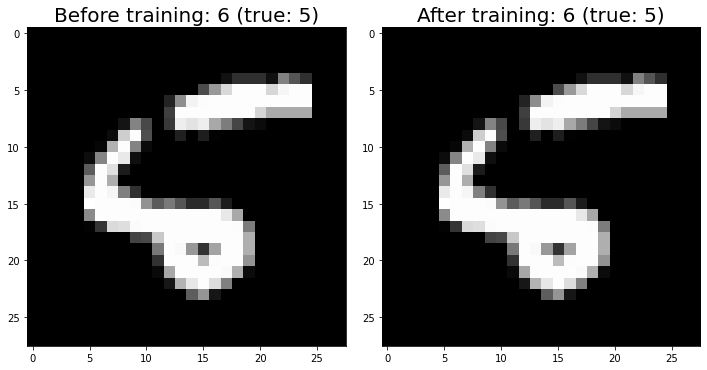

In [12]:
# After training
with torch.no_grad():
    output_after = net(image)
probabilities_after = F.softmax(output_after, dim=1)  # apply softmax
predicted_after = torch.argmax(output_after).item()

# Display the results
print(f"Probabilities before training: {probabilities_before}")
print(f"Probabilities after training: {probabilities_after}")

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(image.view(28, 28), cmap='gray')
plt.title(f'Before training: {predicted_before} (true: {label})', fontsize=20)

plt.subplot(1, 2, 2)
plt.imshow(image.view(28, 28), cmap='gray')
plt.title(f'After training: {predicted_after} (true: {label})', fontsize=20)

plt.tight_layout()
#plt.savefig('digit_3.png', facecolor='w', bbox_inches='tight')
plt.show()

In [13]:
# Define learning rates
learning_rates = [0.01, 0.05, 0.1]

# Placeholder for the accuracies of each learning rate
accuracies = {}

# Training loop for each learning rate
for lr in learning_rates:
    # Instantiate the network, loss function, and optimizer
    net = Net()
    criterion = nn.MSELoss()
    optimizer = optim.SGD(net.parameters(), lr=lr)

    # Placeholder for the accuracy
    accuracy_values = []

    net.eval()  # set the model to evaluation mode
    correct = 0  # to count the number of correct predictions
    total = 0  # to count the total number of predictions

    # Go through the test dataset
    with torch.no_grad():  # deactivate autograd engine to reduce memory usage and speed up computations
        for images, labels in test_loader:
            outputs = net(images)   # forward pass
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total
    accuracy_values.append(accuracy)

    # Training and validation loop
    for epoch in range(5):                #<--------- Choose epoch number (here 10 training epochs)
        epoch_loss = 0  # to accumulate the loss within an epoch
        num_batches = 0  # to count the number of batches

        net.train()  # switch to training mode

        for i, (images, labels) in enumerate(train_loader):
            # Convert labels to one-hot encoding
            labels_one_hot = torch.zeros(labels.size(0), 10).scatter_(1, labels.view(-1, 1), 1)

            optimizer.zero_grad()   # zero the gradient buffers
            outputs = net(images)   # forward pass

            loss = criterion(outputs, labels_one_hot)  # compute the loss
            epoch_loss += loss.item()  # accumulate the loss within the epoch
            num_batches += 1  # count the number of batches

            loss.backward()  # backpropagation
            optimizer.step()  # update the weights

        # Test the model on the test dataset
        correct = 0
        with torch.no_grad():
            for images, labels in test_loader:
                outputs = net(images)
                _, predicted = torch.max(outputs.data, 1)
                correct += (predicted == labels).sum().item()

        accuracy = correct / len(test_dataset)
        accuracy_values.append(accuracy)
    
    # Store the accuracies for this learning rate
    accuracies[lr] = accuracy_values

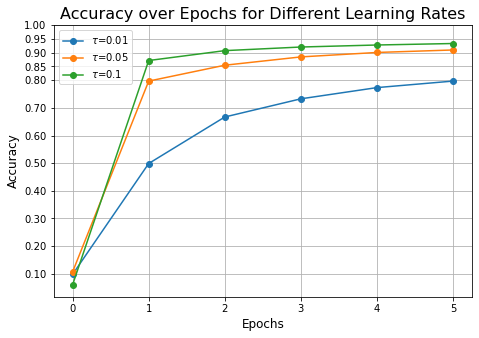

In [14]:
# Now let's plot the results
plt.figure(figsize=(7.5, 5))
for lr, acc in accuracies.items():
    plt.plot(range(0, 6), acc, '-o', label=f'$\\tau$={lr}') #<---------- set the range in accordance with the number of epochs

plt.title('Accuracy over Epochs for Different Learning Rates', fontsize=16)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.legend()

# Set y-ticks
plt.yticks(list(np.arange(0.1, 0.8, 0.1)) + list(np.arange(0.8, 1.050, 0.050)))
#plt.savefig('Accuracy_over_epochs_lr.png', facecolor='w', bbox_inches='tight')
plt.grid()
plt.show()

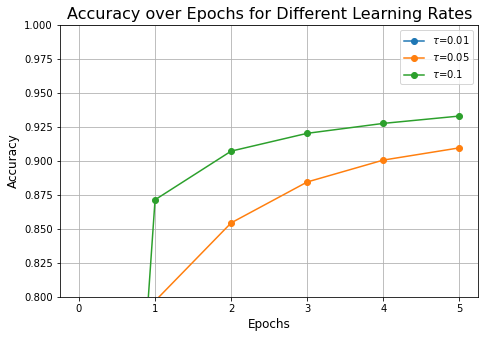

In [15]:
plt.figure(figsize=(7.5, 5))
for lr, acc in accuracies.items():
    plt.plot(range(0, 6), acc, '-o', label=f'$\\tau$={lr}') #<---------- set the range in accordance with the number of epochs

plt.title('Accuracy over Epochs for Different Learning Rates', fontsize=16)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.legend()

# Set y-ticks
plt.yticks(list(np.arange(0.8, 1.025, 0.025)))
plt.ylim(0.8, 1.0)  # limit the range of y-axis from 0.8 to 1.0
#plt.savefig('Accuracy_over_epochs_lr_zoom.png', facecolor='w', bbox_inches='tight')
plt.grid()
plt.show()